In [1]:
import os
import tifffile

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, \
    concatenate, Input, BatchNormalization, Conv2D, Dropout, MaxPooling2D, RNN, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, MeanIoU

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import random

2025-04-30 23:44:35.380096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 23:44:35.380862: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 23:44:35.384025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 23:44:35.391814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746071075.404532  143784 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746071075.40

In [2]:
data_folder = './data/'

# List all year folders.
year_folders = sorted([os.path.join(data_folder, yf) for yf in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, yf))])
print(f"Year folders: {year_folders}")

# List all fire folders inside year folders.
fire_folders = []
for yf in year_folders:
    fires = sorted([os.path.join(yf, ff) for ff in os.listdir(yf) if os.path.isdir(os.path.join(yf, ff))])
    fire_folders.extend(fires)
print(f"Fire folders: {fire_folders}")

# List all .tif files inside each fire folder.
fire_files = []
for ff in fire_folders:
    files = sorted([os.path.join(ff, f) for f in os.listdir(ff) if f.endswith('.tif')])
    files1 = files[:-1]
    files2 = files[1:]
    fire_files.extend([[f1, f2] for f1, f2 in zip( files1, files2 )])

print("Found", len(fire_files), ".tif files.")

Year folders: ['./data/2021']
Fire folders: ['./data/2021/fire_24935867', './data/2021/fire_24935874', './data/2021/fire_24935885', './data/2021/fire_24936357', './data/2021/fire_25017306', './data/2021/fire_25017323', './data/2021/fire_25017384', './data/2021/fire_25017416', './data/2021/fire_25084892', './data/2021/fire_25086458', './data/2021/fire_25086466', './data/2021/fire_25088018', './data/2021/fire_25088019', './data/2021/fire_25138926', './data/2021/fire_25138935', './data/2021/fire_25138942', './data/2021/fire_25138947', './data/2021/fire_25204812', './data/2021/fire_25204815', './data/2021/fire_25204820', './data/2021/fire_25204835', './data/2021/fire_25204848', './data/2021/fire_25204858', './data/2021/fire_25204859', './data/2021/fire_25204868', './data/2021/fire_25204869', './data/2021/fire_25204877', './data/2021/fire_25204897', './data/2021/fire_25204900', './data/2021/fire_25205245', './data/2021/fire_25205247', './data/2021/fire_25205255', './data/2021/fire_25205259'

In [3]:
# Train/test split.
daily_train_files, daily_test_files = train_test_split(fire_files, test_size=0.2, random_state=42)

print("Training samples:", len(daily_train_files))
print("Testing samples:", len(daily_test_files))

Training samples: 3168
Testing samples: 793


# Data Generator

In [4]:
def pad_image_to_target(img, target_height, target_width):
    height, width, channels = img.shape
    pad_height = max(target_height - height, 0)
    pad_width = max(target_width - width, 0)

    # Pad with zeros (black padding).
    padded_img = np.pad(img, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return padded_img

def crop_image_to_target(img, target_height, target_width):
    height, width, channels = img.shape

    # If the image is smaller than the target, return the original (or you could pad instead).
    if height < target_height or width < target_width:
        raise ValueError("Target size must be less than or equal to image size for cropping.")

    # Compute starting coordinates to crop the center.
    start_y = (height - target_height) // 2
    start_x = (width - target_width) // 2

    # Crop the image.
    cropped_img = img[start_y:start_y + target_height, start_x:start_x + target_width, :]

    return cropped_img


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paired_images, batch_size=1, dim=(298,216), shuffle=False):
        self.dim = dim  # (height, width)
        self.batch_size = batch_size
        self.paired_images = np.array( paired_images )
        self.shuffle = shuffle

        self.indexes = np.arange(len(self.paired_images))

        self.clean()
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.paired_images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        paired_images = [self.paired_images[k] for k in indexes]
        X, y = self.__data_generation(paired_images)
        return X, y

    # Clean data before using: remove entries that have innapropriate NaN elements.
    def clean(self):
        clean_images = []
        for index in range(len(self.paired_images)):
            inp_file, out_file = self.paired_images[index]
            inp_img = tifffile.imread(inp_file)
            out_img = tifffile.imread(out_file)
            try:
                i_img = crop_image_to_target(inp_img, *self.dim)
                o_img = crop_image_to_target(out_img, *self.dim)
                coverage = np.mean(i_img[:,:,:-1]) > 0.1 and np.mean(o_img[:,:,:-1]) > 0.1
                is_clean = np.all(np.isfinite(o_img[:, :, :-1])) and coverage
            except:
                is_clean = False
            clean_images.append(is_clean)
        self.paired_images = self.paired_images[clean_images]

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paired_images))
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, paired_images):
        # Fire: 3, 10, 15, 22
        # Weather: 5, 6, 7, 11, 17, 18, 19, 21
        # Topology: 12,13,14
        X_fire = np.empty((self.batch_size, self.dim[0], self.dim[1], 4), dtype='float32')
        X_weat = np.empty((self.batch_size, self.dim[0], self.dim[1], 8), dtype='float32')
        X_topo = np.empty((self.batch_size, self.dim[0], self.dim[1], 3), dtype='float32')
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype='float32')

        for i, (inp_file, out_file) in enumerate(paired_images):
            inp_img = tifffile.imread(inp_file)  # (H, W, C)
            out_img = tifffile.imread(out_file)  # (H, W, C)

            # Pad the image to the target size.
            inp_img_padded = crop_image_to_target(inp_img, *self.dim)
            out_img_padded = crop_image_to_target(out_img, *self.dim)

            # Identify points with 'no fire' (NaN).
            Xnan = np.isfinite( inp_img_padded[:,:,22] )
            ynan = np.isfinite( out_img_padded[:,:,22] )

            # Extract layers to be considered in each model block.
            X_fire[i] = inp_img_padded[:,:,[3,10,15,22]]
            X_weat[i] = inp_img_padded[:,:,[5,6,7,11,17,18,19,21]]
            X_topo[i] = inp_img_padded[:,:,[12,13,14]]
            y[i] = out_img_padded[:,:,22][:,:,None]

            # Adjust fire layers to not include NaN values.
            X_fire[i][Xnan,-1] = 1;  X_fire[i][~Xnan,-1] = 0
            y[i][ynan] = 1;  y[i][~ynan] = 0

        return (X_fire, X_weat, X_topo), y

class ValDataGenerator(DataGenerator):
    pass

In [5]:
training_generator = DataGenerator(daily_train_files, dim=(298,216))
validation_generator = ValDataGenerator(daily_test_files, dim=(298,216))

In [6]:
(Xf, Xw, Xt), y = training_generator[0]

print('Inp. data (fire):', Xf.shape)
print('Inp. data (weather):', Xw.shape)
print('Inp. data (topology):', Xt.shape)
print('Out. data:', y.shape)
print('Total image count:', len(training_generator), len(validation_generator))

Inp. data (fire): (1, 298, 216, 4)
Inp. data (weather): (1, 298, 216, 8)
Inp. data (topology): (1, 298, 216, 3)
Out. data: (1, 298, 216, 1)
Total image count: 1271 321


# Loss functions

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

smooth=1
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

# Physics-Informed Network

### Fire-Intensity Block

In [8]:
def fire_block(input_1):

  x2 = Conv2D(16, (3,3), activation='relu',padding='same') (input_1)
  x2 = Conv2D(32, (3,3), activation='relu',padding='same') (x2)

  x3 = Conv2D(32, (3,3),dilation_rate=3, activation='relu',padding='same') (x2)
  x4 = Conv2D(32, (3,3),dilation_rate=6, activation='relu',padding='same') (x2)
  x5 = Conv2D(32, (3,3),dilation_rate=12, activation='relu',padding='same') (x2)
  x6 = Conv2D(32, (3,3),dilation_rate=1, activation='relu',padding='same') (x2)

  x6 = concatenate([x3,x4,x5,x6])
  x2 = Conv2D(1, (1,1), activation='relu',padding='same') (x6)
  x2 = MaxPooling2D(pool_size=(2, 2)) (x2)
  x2 = Conv2D(16, (3,3), activation='relu',padding='same') (x2)
  x2 = MaxPooling2D(pool_size=(2, 2)) (x2)
  x2 = Conv2D(32, (3,3), activation='relu',padding='same') (x2)
  x2 = MaxPooling2D(pool_size=(2, 2)) (x2)

  x2 = BatchNormalization()(x2)

  x2 = Flatten() (x2)

  x2=Dense(64,activation='relu') (x2)
  x2=Dense(32,activation='relu') (x2)

  return x2

### Weather Block

In [9]:
def weather_block(input_2):
    x2 = Conv2D(16, (3,3), activation='relu', padding='same')(input_2)
    x2 = Conv2D(32, (3,3), activation='relu', padding='same')(x2)

    x3 = Conv2D(32, (3,3), dilation_rate=3, activation='relu', padding='same')(x2)
    x4 = Conv2D(32, (3,3), dilation_rate=6, activation='relu', padding='same')(x2)
    x5 = Conv2D(32, (3,3), dilation_rate=12, activation='relu', padding='same')(x2)
    x6 = Conv2D(32, (3,3), dilation_rate=1, activation='relu', padding='same')(x2)

    x6 = concatenate([x3, x4, x5, x6])
    x2 = Conv2D(1, (1,1), activation='relu', padding='same')(x6)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(16, (3,3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(32, (3,3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)

    x2 = BatchNormalization()(x2)

    x2 = Flatten() (x2)

    x2=Dense(64,activation='relu') (x2)
    x2=Dense(32,activation='relu') (x2)

    return x2


### Vegetation and Topology Block

In [10]:
def vegTop_block(input_3):

  x2 = Conv2D(16, (3,3), activation='relu',padding='same') (input_3)
  x2 = Conv2D(32, (3,3), activation='relu',padding='same') (x2)

  x3 = Conv2D(32, (3,3),dilation_rate=3, activation='relu',padding='same') (x2)
  x4 = Conv2D(32, (3,3),dilation_rate=6, activation='relu',padding='same') (x2)
  x5 = Conv2D(32, (3,3),dilation_rate=12, activation='relu',padding='same') (x2)
  x6 = Conv2D(32, (3,3),dilation_rate=1, activation='relu',padding='same') (x2)

  x6 = concatenate([x3,x4,x5,x6])
  x2 = Conv2D(1, (1,1), activation='relu',padding='same') (x6)
  x2 = MaxPooling2D(pool_size=(2, 2)) (x2)
  x2 = Conv2D(16, (3,3), activation='relu',padding='same') (x2)
  x2 = MaxPooling2D(pool_size=(2, 2)) (x2)
  x2 = Conv2D(32, (3,3), activation='relu',padding='same') (x2)
  x2 = MaxPooling2D(pool_size=(2, 2)) (x2)

  x2 = BatchNormalization() (x2)

  x2 = Flatten() (x2)

  x2=Dense(64,activation='relu') (x2)
  x2=Dense(32,activation='relu') (x2)

  return x2

### Combination of all 3 blocks

In [11]:
def PhysicsInformedNN(input_shape1,input_shape2,input_shape3):
  # Get Inputs
  input_1 = Input(input_shape1)
  input_2 = Input(input_shape2)
  input_3 = Input(input_shape3)

  # create the 3 blocks
  out1 = fire_block(input_1)
  out2 = weather_block(input_2)
  out3 = vegTop_block(input_3)

  # combination of all blocks
  x = concatenate([out1,out2,out3])
  x = Dense(128,activation='relu') (x)
  x = Dropout(0.4) (x)
  x = Dense(298*216, activation='sigmoid') (x)

  # create output
  out = tf.keras.layers.Reshape((298,216,1)) (x)
  return Model(inputs=(input_1,input_2,input_3),outputs=out)

In [12]:
inp1 = (298,216,4)
inp2 = (298,216,8)
inp3 = (298,216,3)

model = PhysicsInformedNN(inp1, inp2, inp3)
model.summary()

2025-04-30 23:50:46.921749: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 298, 216,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 298, 216,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 298, 216,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 298, 216,  │        592 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 298, 216,  │      1,168 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 298, 216,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 298, 216,  │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 298, 216,  │      4,640 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 298, 216,  │      4,640 │ conv2d_18[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 298, 216,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 298, 216,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 298, 216,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 298, 216,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 298, 216,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 298, 216,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 298, 216,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 298, 216,  │      9,248 │ conv2d_10[0][0] 

 Total params: 14,602,451 (55.70 MB)

 Trainable params: 14,602,259 (55.70 MB)

 Non-trainable params: 192 (768.00 B)

In [13]:
learning_rate = 0.0005
decay_rate = learning_rate / 200

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_binary = tf.keras.losses.BinaryCrossentropy()

model.compile(
    loss=loss_binary,
    optimizer=optimizer,
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        MeanIoU(num_classes=2, name='mean_iou')  # for binary segmentation
    ]
)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_jac_distance", patience=25)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=25)

model_path_save = './Model_PhysicsNN.keras'
chek_point = ModelCheckpoint(model_path_save, verbose=1, save_best_only=True)
callbacks = [chek_point,early_stopping,reduce_lr]

In [16]:
hst = model.fit(training_generator, epochs=75, validation_data=validation_generator)

Epoch 1/75
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 334s 263ms/step - accuracy: 0.9984 - auc: 0.6619 - loss: 0.0122 - mean_iou: 0.4996 - precision: 0.0047 - recall: 1.0561e-05 - val_accuracy: 0.9982 - val_auc: 0.7261 - val_loss: 0.0160 - val_mean_iou: 0.4991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 337s 265ms/step - accuracy: 0.9984 - auc: 0.6932 - loss: 0.0116 - mean_iou: 0.4992 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9982 - val_auc: 0.7436 - val_loss: 0.0125 - val_mean_iou: 0.4991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/75
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - accuracy: 0.9983 - auc: 0.7253 - loss: 0.0116 - mean_iou: 0.5003 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9982 - val_auc: 0.7648 - val_loss: 0.0143 - val_mean_iou: 0.4991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/75
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 331s 261ms/step - accuracy: 0.9985 - auc: 0.

In [21]:
model.save(model_path_save)
np.save( 'History_PhysicsNN', hst.history )

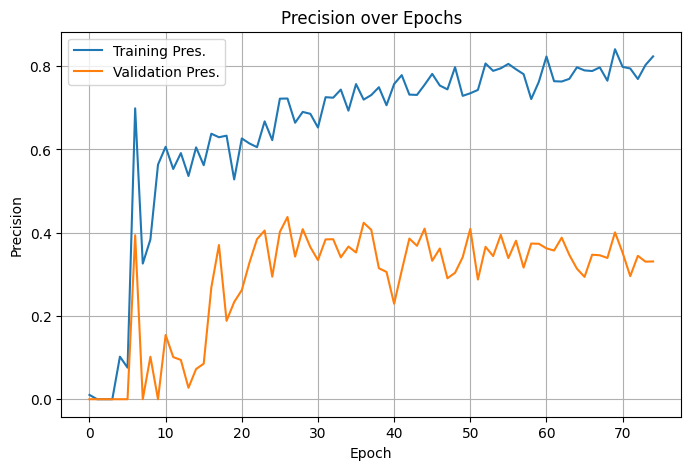

In [23]:
# Get training and validation loss
loss = hst.history['precision']
val_loss = hst.history.get('val_precision')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Pres.')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Pres.')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()
plt.grid(True)
plt.show()
